In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


from numpy.random import seed
seed(7)
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [2]:
df = pd.read_csv("processminer-rare-event-mts - data.csv") 
df.head(n=5)  # visualize the data.

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [3]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [4]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


After shifting


,y,time,x1,x2,x3
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,0.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954
260,0.0,5/1/99 10:50,0.020062,-3.987897,-1.248529


In [5]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [6]:
# view summary statistics in numerical variables

round(df.describe(),2)

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
count,18274.00,18274.00,18274.00,18274.00,18274.00,18274.00,18274.00,18274.00,18274.00,18274.00,...,18274.00,18274.00,18274.00,18274.00,18274.00,18274.00,18274.00,18274.00,18274.00,18274.00
mean,0.01,0.01,0.19,0.63,-10.14,0.01,2.49,0.00,-0.00,-0.00,...,-3.58,0.40,0.46,0.18,2.45,9.40,0.24,-0.00,-0.07,0.00
std,0.12,0.74,4.91,5.90,130.98,0.63,36.99,0.11,0.08,0.16,...,349.43,6.05,4.61,3.02,67.89,81.29,2.32,0.05,10.43,0.00
min,0.00,-3.79,-17.32,-18.20,-322.78,-1.62,-279.41,-0.43,-0.45,-0.12,...,-3652.99,-16.56,-14.21,-8.21,-230.57,-269.04,-4.89,-0.15,-100.81,-0.01
25%,0.00,-0.41,-2.12,-3.48,-111.43,-0.45,-23.69,-0.06,-0.05,-0.06,...,29.98,-3.67,-1.93,0.49,-39.88,-45.40,-1.60,0.00,0.30,-0.00
50%,0.00,0.13,-0.06,-0.16,-14.94,-0.12,10.59,-0.01,-0.00,-0.03,...,29.98,0.29,0.14,0.71,17.63,1.68,0.09,0.01,0.73,0.00
75%,0.00,0.42,2.34,3.44,92.05,0.33,32.21,0.06,0.04,0.00,...,29.98,5.13,3.24,2.68,44.11,63.32,2.22,0.02,1.27,0.00
max,1.00,3.05,16.74,15.90,334.69,2.37,96.06,1.71,0.55,4.06,...,37.68,14.18,11.15,6.64,287.25,252.15,6.92,0.07,6.99,0.02


Text(0, 0.5, 'x8')

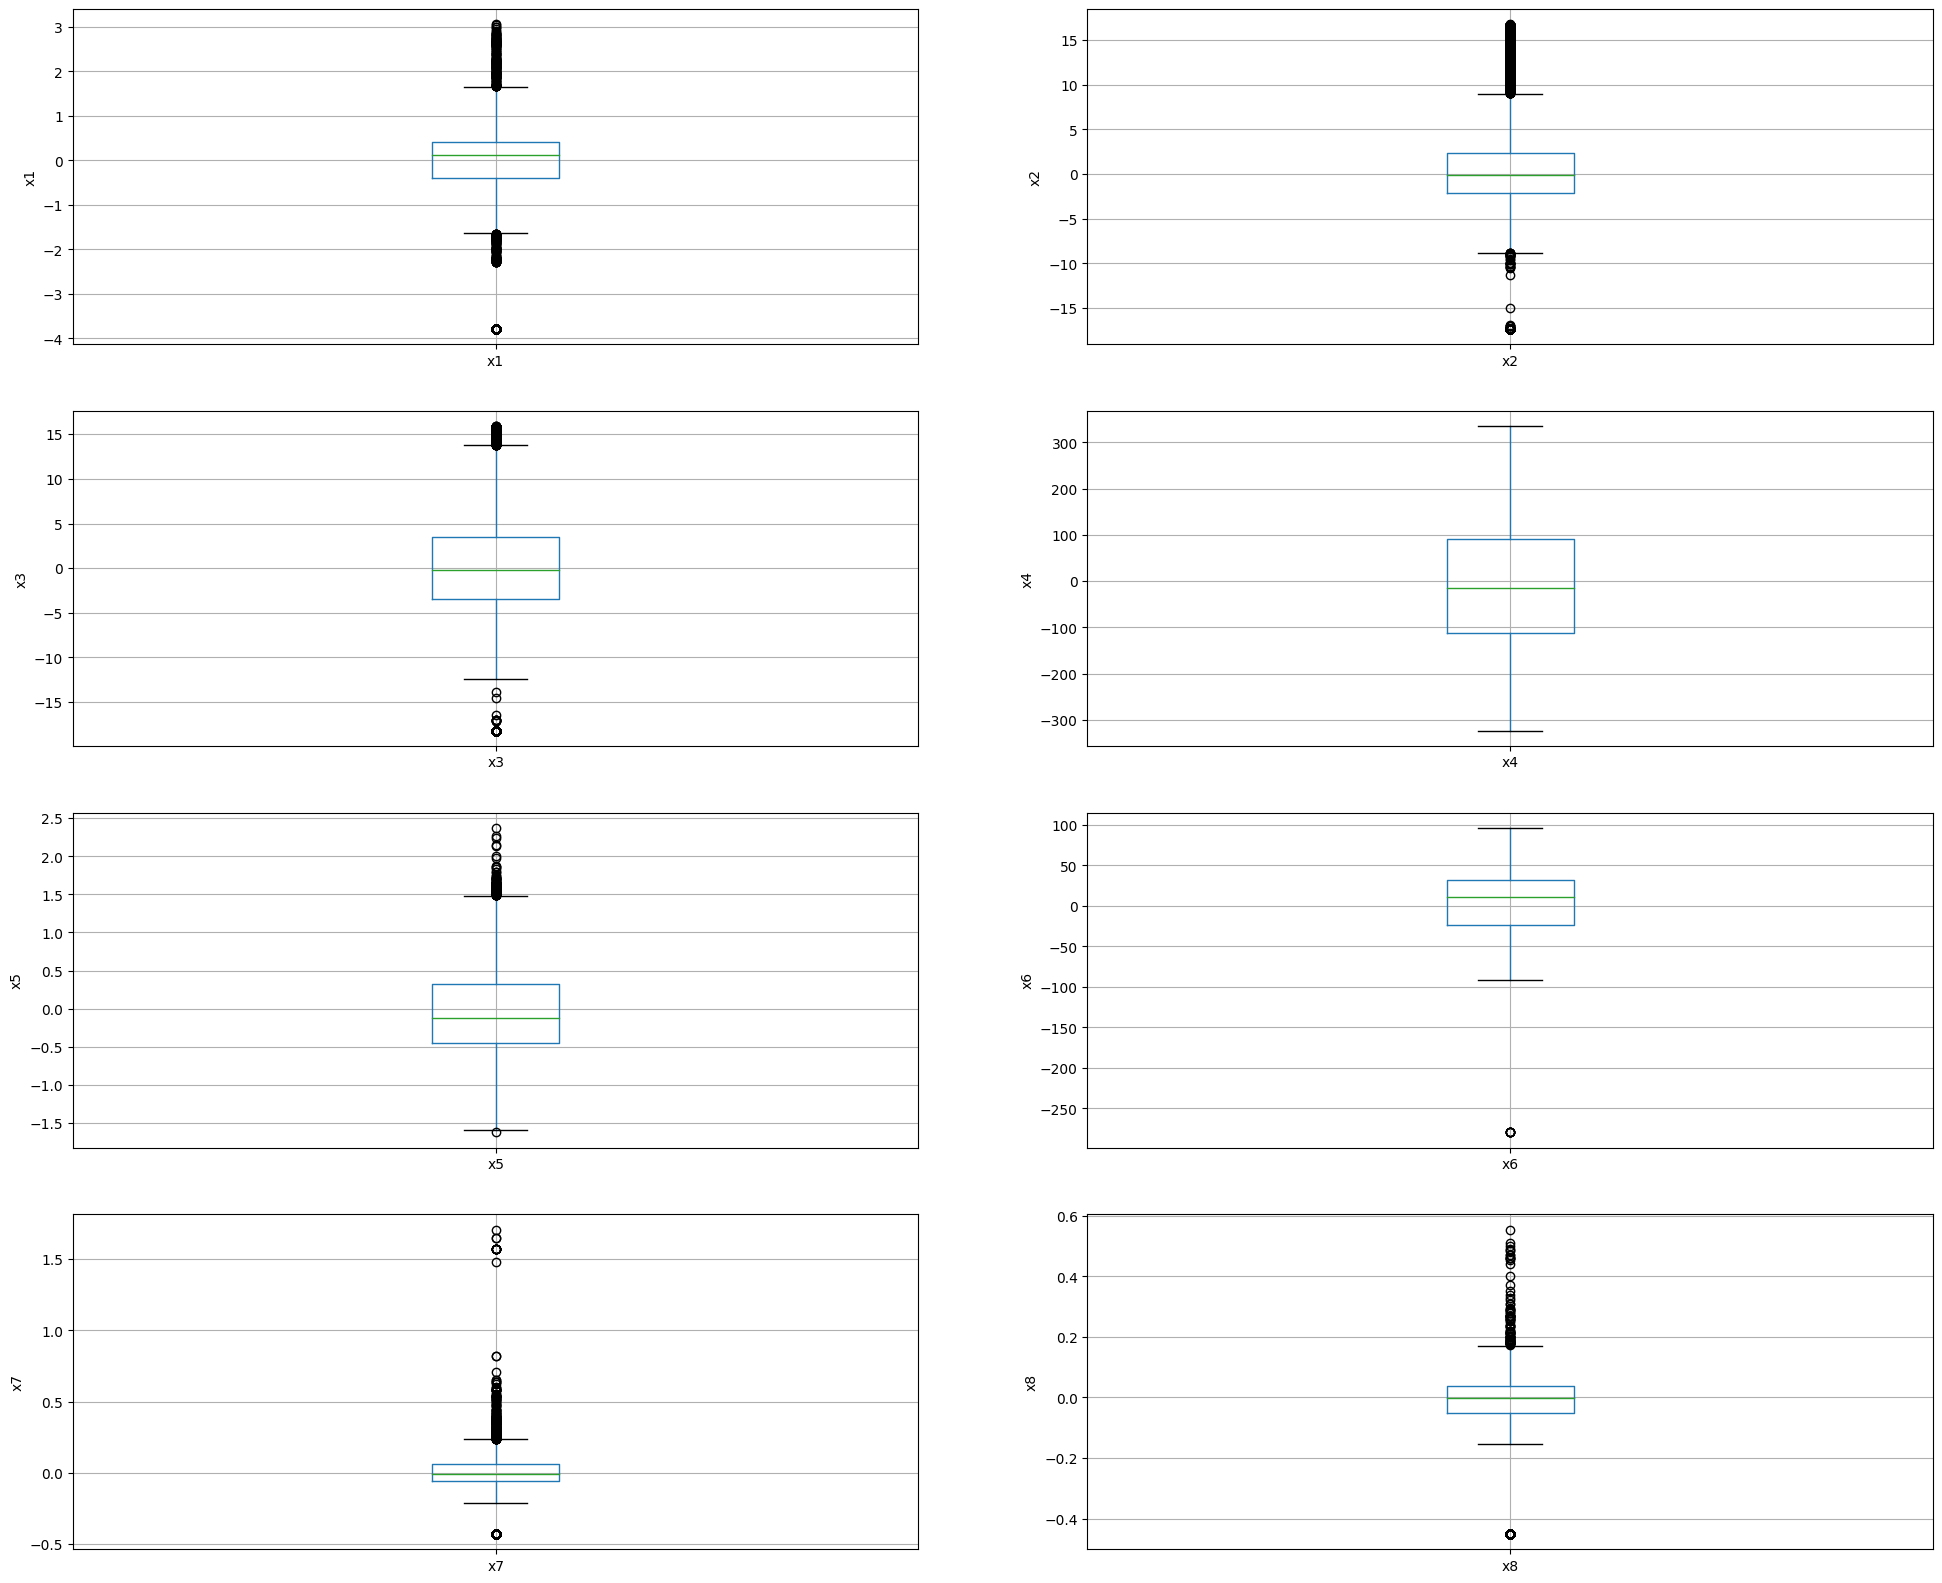

In [7]:
# draw boxplots to visualize outliers

plt.figure(figsize=(24,20))

plt.subplot(4, 2, 1)
fig = df.boxplot(column='x1')
fig.set_title('')
fig.set_ylabel('x1')

plt.subplot(4, 2, 2)
fig = df.boxplot(column='x2')
fig.set_title('')
fig.set_ylabel('x2')

plt.subplot(4, 2, 3)
fig = df.boxplot(column='x3')
fig.set_title('')
fig.set_ylabel('x3')

plt.subplot(4, 2, 4)
fig = df.boxplot(column='x4')
fig.set_title('')
fig.set_ylabel('x4')

plt.subplot(4, 2, 5)
fig = df.boxplot(column='x5')
fig.set_title('')
fig.set_ylabel('x5')

plt.subplot(4, 2, 6)
fig = df.boxplot(column='x6')
fig.set_title('')
fig.set_ylabel('x6')

plt.subplot(4, 2, 7)
fig = df.boxplot(column='x7')
fig.set_title('')
fig.set_ylabel('x7')

plt.subplot(4, 2, 8)
fig = df.boxplot(column='x8')
fig.set_title('')
fig.set_ylabel('x8')

Text(0, 0.5, 'x6')

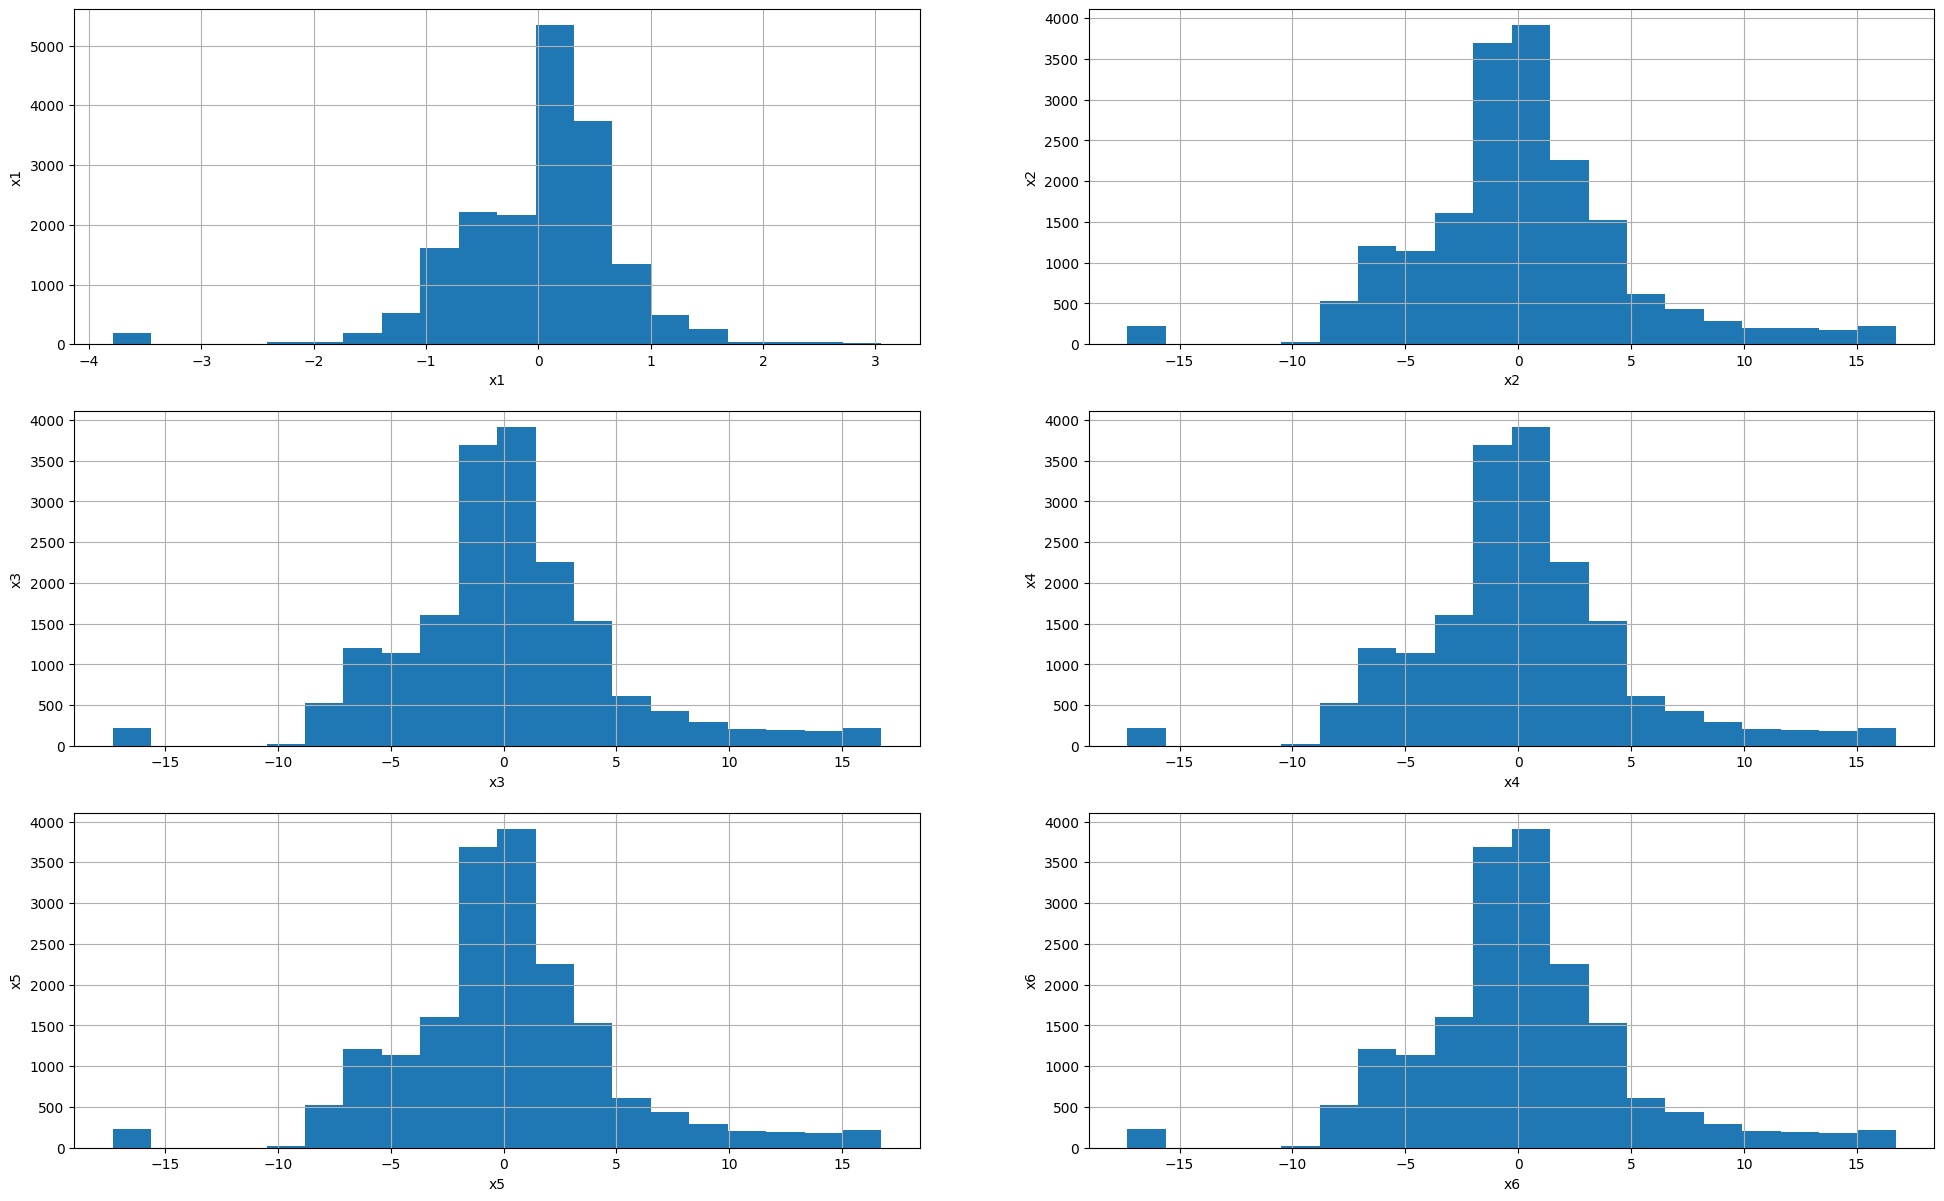

In [8]:
# plot histogram to check distribution

plt.figure(figsize=(24,20))

plt.subplot(4, 2, 1)
fig = df['x1'].hist(bins=20)
fig.set_xlabel('x1')
fig.set_ylabel('x1')

plt.subplot(4, 2, 2)
fig = df['x2'].hist(bins=20)
fig.set_xlabel('x2')
fig.set_ylabel('x2')

plt.subplot(4, 2, 3)
fig = df['x2'].hist(bins=20)
fig.set_xlabel('x3')
fig.set_ylabel('x3')

plt.subplot(4, 2, 4)
fig = df['x2'].hist(bins=20)
fig.set_xlabel('x4')
fig.set_ylabel('x4')

plt.subplot(4, 2, 5)
fig = df['x2'].hist(bins=20)
fig.set_xlabel('x5')
fig.set_ylabel('x5')

plt.subplot(4, 2, 6)
fig = df['x2'].hist(bins=20)
fig.set_xlabel('x6')
fig.set_ylabel('x6')


In [9]:
X = df.drop(['y'], axis=1)

y = df['y']

In [10]:
# split X and y into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [11]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((14619, 59), (3655, 59))

# Feature scaling

In [12]:
cols = X_train.columns

In [13]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [14]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [15]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [16]:
X_train.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
count,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,...,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04,1.461900e+04
mean,1.088180e-17,4.002430e-17,2.257051e-17,1.054480e-17,6.432443e-18,-8.118397e-18,4.211086e-17,2.248773e-16,1.301374e-16,-2.182094e-16,...,2.698911e-16,1.637349e-17,-3.659012e-16,2.055040e-17,1.778605e-17,-1.494575e-17,2.402104e-17,-8.288131e-17,7.122939e-17,-3.295203e-17
std,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,...,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00
min,-5.125384e+00,-3.567254e+00,-3.189176e+00,-2.395565e+00,-2.570421e+00,-7.614198e+00,-3.951148e+00,-5.922619e+00,-7.462128e-01,-8.818439e-01,...,-1.047612e+01,-2.809865e+00,-3.183917e+00,-1.837096e+00,-3.438819e+00,-3.446922e+00,-2.116882e+00,-3.034917e+00,-9.679382e+00,-2.849635e+00
25%,-5.554024e-01,-4.714467e-01,-6.972715e-01,-7.769985e-01,-7.144949e-01,-7.130750e-01,-5.405372e-01,-6.213737e-01,-3.618129e-01,-4.201017e-01,...,9.578457e-02,-6.745255e-01,-5.237619e-01,1.000009e-01,-6.213750e-01,-6.774386e-01,-7.900745e-01,4.856733e-02,3.488246e-02,-6.491602e-01
50%,1.588102e-01,-5.119891e-02,-1.344593e-01,-3.828396e-02,-1.987992e-01,2.197745e-01,-1.003659e-01,4.178211e-02,-1.705816e-01,-1.441820e-01,...,9.578457e-02,-1.687841e-02,-7.083909e-02,1.738554e-01,2.230317e-01,-9.516044e-02,-6.412583e-02,3.028169e-01,7.701739e-02,-1.221622e-01
75%,5.538925e-01,4.302703e-01,4.767771e-01,7.841977e-01,5.051676e-01,8.045534e-01,5.178168e-01,5.714986e-01,2.275346e-02,1.317470e-01,...,9.578457e-02,7.726337e-01,5.996528e-01,8.229735e-01,6.132136e-01,6.665336e-01,8.564547e-01,4.686952e-01,1.277283e-01,5.986484e-01
max,4.106976e+00,3.374047e+00,2.586934e+00,2.629739e+00,3.723251e+00,2.525914e+00,1.562544e+01,7.393166e+00,2.598052e+01,2.698055e+01,...,1.177435e-01,2.284785e+00,2.322079e+00,2.130941e+00,4.206490e+00,3.005709e+00,2.881752e+00,1.418302e+00,6.775393e-01,4.069762e+00


# Run SVM with default hyperparameters 


In [26]:
# instantiate classifier with default hyperparameters
svc=SVC() 
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with default hyperparameters: 0.9871


In [28]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[3608    0]
 [  47    0]]


In [30]:
target_names = ['Normal', 'Break']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      3608
       Break       0.00      0.00      0.00        47

    accuracy                           0.99      3655
   macro avg       0.49      0.50      0.50      3655
weighted avg       0.97      0.99      0.98      3655



/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

# Run SVM with rbf kernel and C=100.0

In [31]:
# instantiate classifier with rbf kernel and C=100
svc=SVC(C=100.0) 
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with rbf kernel and C=100.0 : 0.9844


In [32]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
target_names = ['Normal', 'Break']
print(classification_report(y_test, y_pred, target_names=target_names))

Confusion matrix

 [[3587   21]
 [  36   11]]
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      3608
       Break       0.34      0.23      0.28        47

    accuracy                           0.98      3655
   macro avg       0.67      0.61      0.64      3655
weighted avg       0.98      0.98      0.98      3655



# Run SVM with rbf kernel and C=1000.0

In [33]:
# instantiate classifier with rbf kernel and C=1000
svc=SVC(C=1000.0) 
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with rbf kernel and C=1000.0 : 0.9830


In [34]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
target_names = ['Normal', 'Break']
print(classification_report(y_test, y_pred, target_names=target_names))

Confusion matrix

 [[3580   28]
 [  34   13]]
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      3608
       Break       0.32      0.28      0.30        47

    accuracy                           0.98      3655
   macro avg       0.65      0.63      0.64      3655
weighted avg       0.98      0.98      0.98      3655



# Run SVM with linear kernel

In [35]:
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0) 
linear_svc.fit(X_train,y_train)
y_pred_test=linear_svc.predict(X_test)
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with linear kernel and C=1.0 : 0.9871


In [37]:
cm = confusion_matrix(y_test, y_pred_test)
print('Confusion matrix\n\n', cm)
target_names = ['Normal', 'Break']
print(classification_report(y_test, y_pred_test, target_names=target_names))

Confusion matrix

 [[3608    0]
 [  47    0]]
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      3608
       Break       0.00      0.00      0.00        47

    accuracy                           0.99      3655
   macro avg       0.49      0.50      0.50      3655
weighted avg       0.97      0.99      0.98      3655



/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [17]:
# instantiate classifier with linear kernel and C=100.0
linear_svc=SVC(kernel='linear', C=100.0) 
linear_svc.fit(X_train,y_train)
y_pred_test=linear_svc.predict(X_test)
print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Model accuracy score with linear kernel and C=100.0 : 0.9871


/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [18]:
cm = confusion_matrix(y_test, y_pred_test)
print('Confusion matrix\n\n', cm)
target_names = ['Normal', 'Break']
print(classification_report(y_test, y_pred_test, target_names=target_names))

Confusion matrix

 [[3608    0]
 [  47    0]]
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      3608
       Break       0.00      0.00      0.00        47

    accuracy                           0.99      3655
   macro avg       0.49      0.50      0.50      3655
weighted avg       0.97      0.99      0.98      3655



/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [19]:
#Compare the train-set and test-set accuracy
y_pred_train = linear_svc.predict(X_train)

y_pred_train

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Training-set accuracy score: 0.9863


In [20]:
# print classification accuracy
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.9871


# Stratified k-fold Cross Validation with shuffle split

In [21]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold=KFold(n_splits=5, shuffle=True, random_state=0)
linear_svc=SVC(kernel='linear')
linear_scores = cross_val_score(linear_svc, X, y, cv=kfold)

In [22]:
# print cross-validation scores with linear kernel
print('Stratified cross-validation scores with linear kernel:\n\n{}'.format(linear_scores))

Stratified cross-validation scores with linear kernel:

[0.9876881  0.98823529 0.98303694 0.98358413 0.98905309]


In [23]:
# print average cross-validation score with linear kernel
print('Average stratified cross-validation score with linear kernel:{:.4f}'.format(linear_scores.mean()))

Average stratified cross-validation score with linear kernel:0.9863


# Hyperparameter Optimization using GridSearch CV

In [ ]:
# import GridSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

svc=SVC() 

# declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]


grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_search.fit(X_train, y_train)

/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got

In [ ]:
# examine the best model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

In [ ]:
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))